In [1]:
# Launch from command line
# python -m notebook

# Import packages
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

pd.set_option("display.max_columns", None)  # show all columns

In [2]:
# Polars
start_time = time.perf_counter()
df = pl.read_csv("../data/detroit_open_data_portal_property_sales.csv", infer_schema_length=10000)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Code execution took: {elapsed_time:.4f} seconds")

Code execution took: 0.5620 seconds


In [3]:
start_time = time.perf_counter()
df = pd.read_csv("../data/detroit_open_data_portal_property_sales.csv")
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Code execution took: {elapsed_time:.4f} seconds")

print("Length of raw dataset", len(df))

##OPTIONAL FILTER ON PROPERTY CLASS CODE
# 401 - Residental - Improved (not vancant)
# 402 - Vancant Residential Property
# 403 - Residential - Common Element/Assessed with Others (i.e Condo)
# 201 - Commerical - Improved 
# 202 - Commerical (Vacant)
# 301 - Industrial Improved
df = df[df['Property Class Code'] == 401]
print("Length of Filtered dataset", len(df))



df["Sale Date"] = pd.to_datetime(df["Sale Date"])
# Extract month and year
df["month"] = df["Sale Date"].dt.month
df["year"] = df["Sale Date"].dt.year


df.head(3)

c:\users\matt\desktop\dataprojects\detroit_property_prices\venv\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (19,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Code execution took: 3.2630 seconds
Length of raw dataset 495578
Length of Filtered dataset 354859


,Sales ID,Parcel ID,Address,Sale Date,Sale Price,Grantor,Grantee,Liber Page,Terms of Sale,Sale Verification,Sale Instrument,sale_number,Property Transfer Percentage,Multi Parcel Sale,Property Class Code,Property Class Description,ECF Neighborhood,Neighborhood,Council District,Zip Code,Street Number,Street Prefix,Street Name,Street Type,Unit Number,Longitude,Latitude,ObjectId,x,y,month,year
210,1471979,27110313.,21730 KINGSVILLE,2011-12-30,37000,"JONES, TERRELL","WASHINGTON, ERIN M",NaN,19-MULTI PARCEL ARM'S LENGTH,TITLE COMPANY,PTA,1,100,True,401.0,RESIDENTIAL,NZH45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2475,NaN,NaN,12,2011
317,1488297,01000767.,287 WATSON,2014-09-10,3698,WAYNE COUNTY TREASURER,CITY OF DETROIT-P&DD,L45397 P1633,13-GOVERNMENT,DEED,QC,1,0,True,401.0,RESIDENTIAL,6R610,Brush Park,5.0,48201,287.0,NaN,WATSON,NaN,NaN,-83.052697,42.346481,3185,-9.245384e+06,5.213023e+06,9,2014
339,1489725,01002593.,246 E PHILADELPHIA,2012-07-20,88,THOR REAL ESTATE LLC,"GADDIS, ANTONIO",NaN,21-NOT USED/OTHER,PROPERTY TRANSFER AFFIDAVIT,PTA,1,100,False,401.0,RESIDENTIAL,5R514,North End,5.0,48202,246.0,E,PHILADELPHIA,NaN,NaN,-83.075244,42.378914,3529,-9.247894e+06,5.217909e+06,7,2012


In [4]:
# Basic statistics
print(df.shape)
print(f"Number of unique Sales: {df['Sales ID'].nunique()}")

# Get earliest and latest dates
print(f"Earliest sales date: {df['Sale Date'].min()}")
print(f"Most recent sales date: {df['Sale Date'].max()}")
print("--------------------")

# Number of NaN values per column
print(f"NaN values (% of rows) per column:\n{(df.isna().sum() / len(df) * 100).round(2)}%")
print("--------------------")

## Number of Zip Codes
# Cleaning Zip Codes to just be the first part before the - 
# Example: 48235-1546 will now be 48235
df['Zip Code'] = df['Zip Code'].str.split('-').str[0]
print(f"Number of Unique Zip Codes {len(df['Zip Code'].value_counts())}")
print(f"Zip Codes {df['Zip Code'].value_counts()}")


(354859, 32)
Number of unique Sales: 354859
Earliest sales date: 2011-01-01 00:00:00
Most recent sales date: 2025-09-12 00:00:00
--------------------
NaN values (% of rows) per column:
Sales ID                         0.00
Parcel ID                        0.20
Address                          0.00
Sale Date                        0.00
Sale Price                       0.00
Grantor                          0.03
Grantee                          0.38
Liber Page                      42.92
Terms of Sale                    0.00
Sale Verification                0.26
Sale Instrument                  0.00
sale_number                      0.00
Property Transfer Percentage     0.00
Multi Parcel Sale                0.00
Property Class Code              0.00
Property Class Description       0.00
ECF Neighborhood                 0.00
Neighborhood                     1.60
Council District                 1.60
Zip Code                         0.42
Street Number                    0.36
Street Prefix    

## Sales Over Time

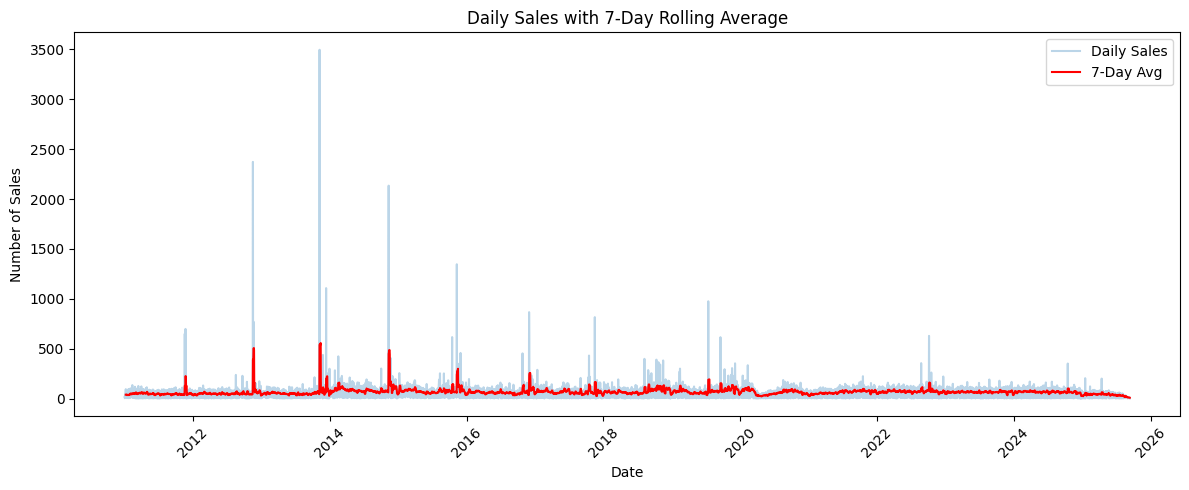

In [5]:
# Daily
sales_by_day = df.groupby("Sale Date")["Sales ID"].count().reset_index()
sales_by_day["rolling_7d"] = sales_by_day["Sales ID"].rolling(7).mean()

plt.figure(figsize=(12,5))
plt.plot(sales_by_day["Sale Date"], sales_by_day["Sales ID"], alpha=0.3, label="Daily Sales")  # faded raw
plt.plot(sales_by_day["Sale Date"], sales_by_day["rolling_7d"], color="red", label="7-Day Avg")   # smoothed
plt.title("Daily Sales with 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
top_10_days = sales_by_day.sort_values(by="Sales ID", ascending=False).head(10)
print("Average sales per day:", sales_by_day["Sales ID"].mean())
top_10_days

Average sales per day: 66.54022126382898


,Sale Date,Sales ID,rolling_7d
1035,2013-11-07,3496,538.571429
681,2012-11-16,2372,390.142857
1403,2014-11-11,2134,451.000000
1766,2015-11-10,1346,240.000000
1070,2013-12-12,1107,198.714286
3107,2019-07-15,975,188.285714
2152,2016-11-30,866,153.714286
2502,2017-11-16,816,161.000000
684,2012-11-19,771,492.285714
1402,2014-11-10,717,153.571429


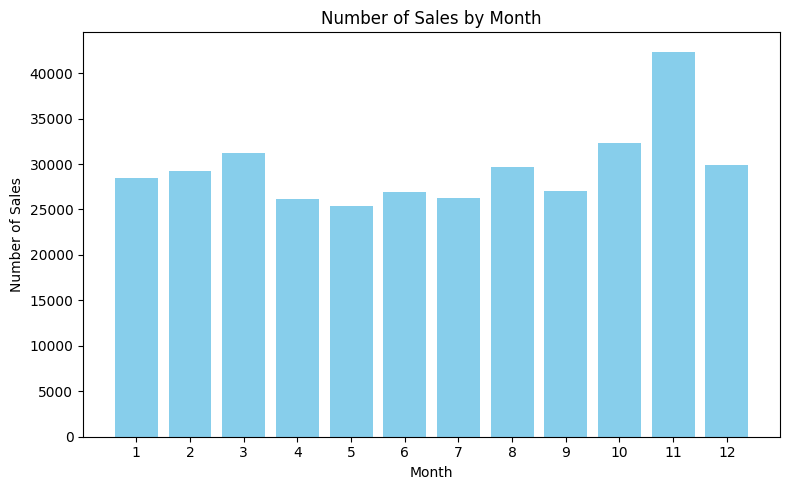

In [7]:
# Group by month only
sales_by_month = df.groupby("month")["Sales ID"].count().reset_index()

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(sales_by_month["month"], sales_by_month["Sales ID"], color="skyblue")

plt.title("Number of Sales by Month")
plt.xlabel("Month")
plt.ylabel("Number of Sales")
plt.xticks(range(1,13))  # show months 1–12
plt.tight_layout()
plt.show()

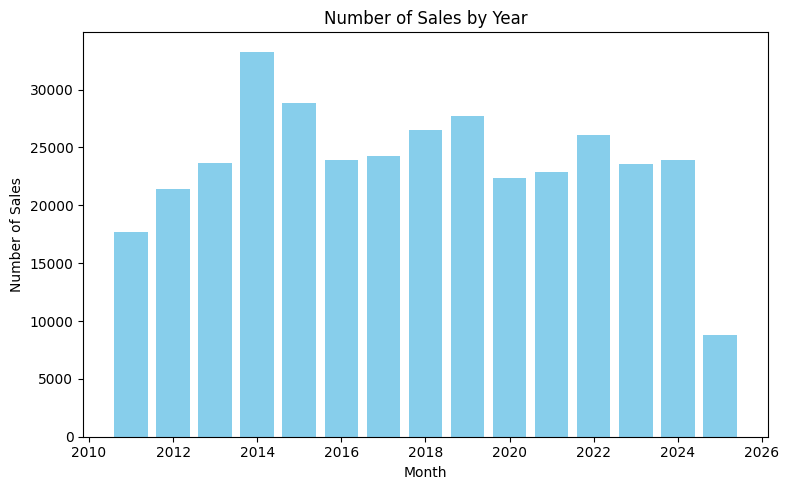

In [8]:
# Group by year only
sales_by_year = df.groupby("year")["Sales ID"].count().reset_index()

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(sales_by_year["year"], sales_by_year["Sales ID"], color="skyblue")

plt.title("Number of Sales by Year")
plt.xlabel("Month")
plt.ylabel("Number of Sales")
plt.tight_layout()
plt.show()

## Sales Price

In [9]:
# Price of Sales
pd.set_option("display.float_format", "{:.2f}".format)
percentiles = [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
print(df['Sale Price'].describe(percentiles=percentiles))
print("------------------")

print("Largest n sales in Detroit Dataset")
print(df[['Address', 'Sale Date', 'Sale Price']].sort_values(by='Sale Price', ascending=False).head(20))


count     354859.00
mean       32844.22
std       175439.90
min            0.00
1%             0.00
5%             0.00
10%            0.00
25%            1.00
50%         3850.00
75%        31000.00
90%        77000.00
95%       130000.00
99%       310740.00
max     20000000.00
Name: Sale Price, dtype: float64
------------------
Largest n sales in Detroit Dataset
                  Address  Sale Date  Sale Price
333476      18439 HICKORY 2021-09-21    20000000
107066      16249 ARDMORE 2014-05-15    11026215
471613     5210 BERKSHIRE 2024-10-16    10162024
144344       19618 ANNOTT 2015-01-15     9203597
11897          165 SIBLEY 2013-12-10     7799968
477347  19156 MURRAY HILL 2025-01-17     7380000
477278    18701 MANSFIELD 2025-01-17     7380000
477231     18331 PEMBROKE 2025-01-17     7380000
477236       17274 BRAILE 2025-01-17     7380000
477263     18426 ROSEMONT 2025-01-17     7380000
477360     19175 BILTMORE 2025-01-17     7380000
477269    18426 STANSBURY 2025-01-17     7380

The 0.9th percentile threshold is: $77,000.00


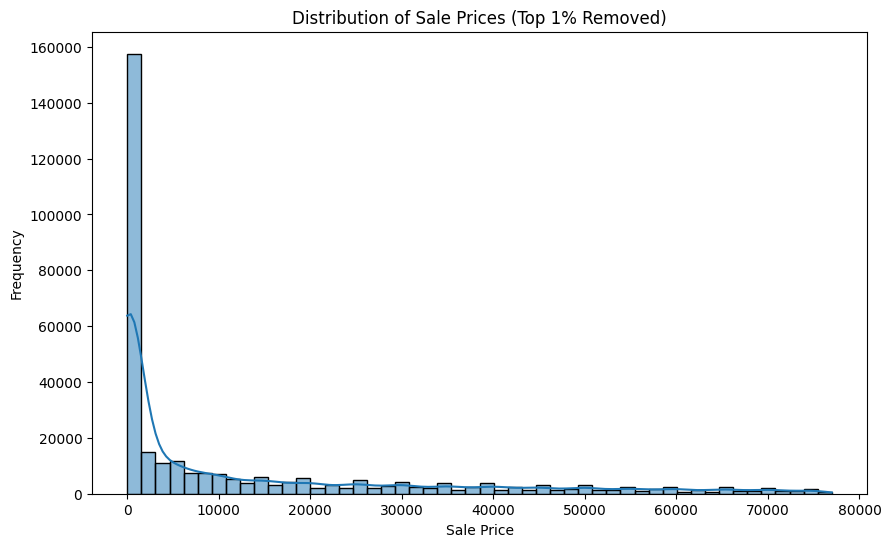

In [10]:
## The Max Sale Price is throwing off the plot... since removed to anythhing less than the 99th percentile
quantile =.90
upper_limit = df['Sale Price'].quantile(quantile)
print(f"The {quantile}th percentile threshold is: ${upper_limit:,.2f}")

df_trimmed = df[df['Sale Price'] < upper_limit]

plt.figure(figsize=(10, 6))
sns.histplot(df_trimmed['Sale Price'], bins=50, kde=True)
plt.title('Distribution of Sale Prices (Top 1% Removed)')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

c:\users\matt\desktop\dataprojects\detroit_property_prices\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


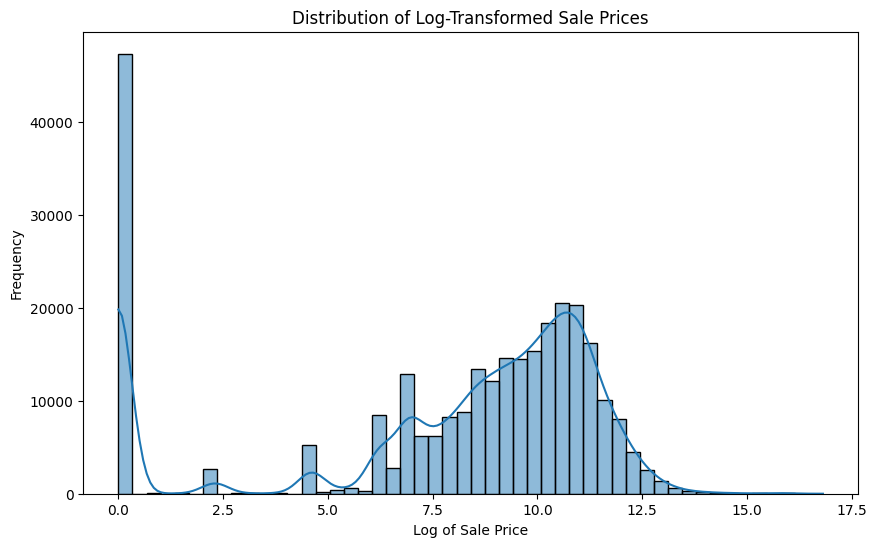

In [11]:
# Distrubution of the Sale Price (Outlier is skewing the plot)
plt.figure(figsize=(10, 6))
df['Log Sale Price'] = np.log(df['Sale Price'])
sns.histplot(df['Log Sale Price'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Sale Prices')
plt.xlabel('Log of Sale Price')
plt.ylabel('Frequency')
plt.show()

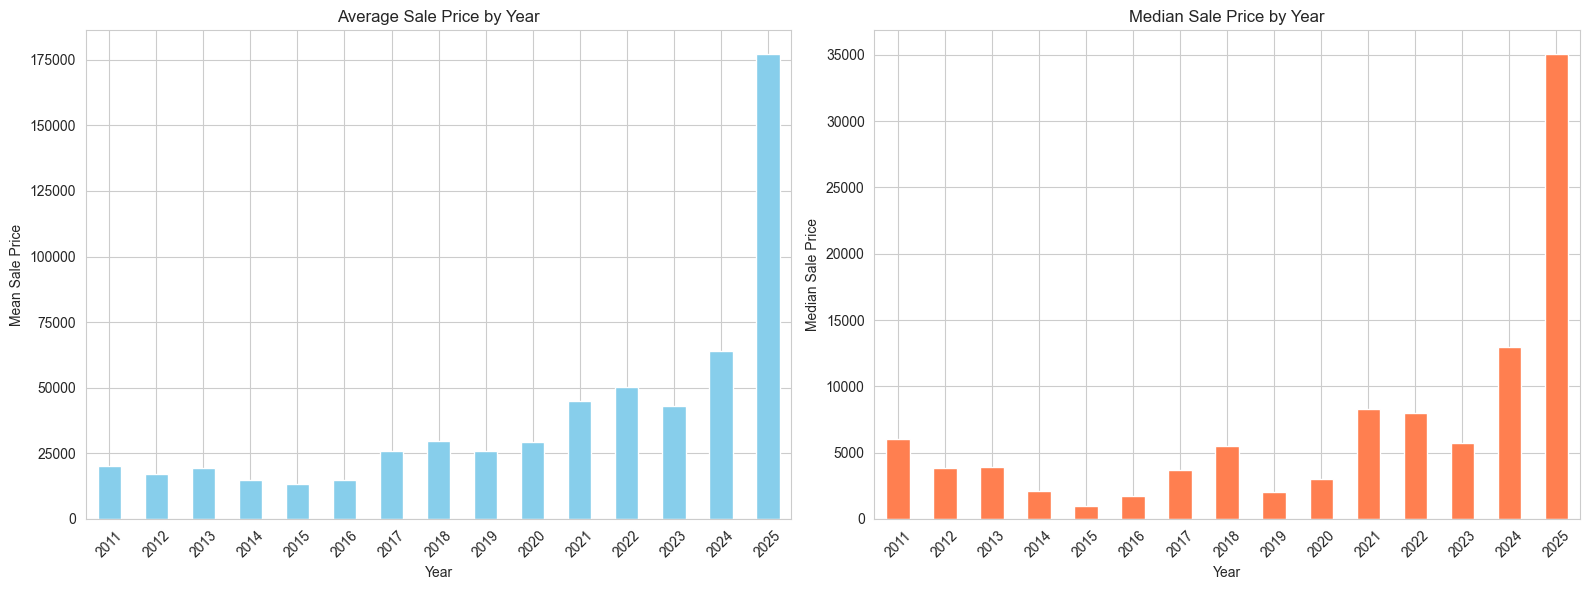

In [12]:
# Is the average price of property in Detroit on the rise..? Median...? 

# Code is from Gemini
# Set up a nicer style for the plots (optional)
sns.set_style("whitegrid")

# --- Step 1: Group the DataFrame and calculate the mean and median ---
mean_prices = df.groupby('year')['Sale Price'].mean()
median_prices = df.groupby('year')['Sale Price'].median()

# --- Step 2: Create a figure with two subplots side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Step 3: Plot the mean prices on the first subplot (ax1) ---
mean_prices.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Average Sale Price by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Sale Price')
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability

# --- Step 4: Plot the median prices on the second subplot (ax2) ---
median_prices.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Median Sale Price by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Median Sale Price')
ax2.tick_params(axis='x', rotation=45) # Rotate x-axis labels

# --- Step 5: Adjust layout and display the plots ---
plt.tight_layout() # This ensures titles and labels don't overlap
plt.show()

## Location 

In [13]:
# Number of neighborhoods (done)
# price by zipcodes (done)
# Common streets (done)
# Look into street types (done)
# property class codes (look into this) --> Good to know... need to filter data on this


In [14]:
print(df['Neighborhood'].nunique())
print(df['Neighborhood'].value_counts().head(20))
print("------------")
print("Highest Median Price by Neighborhood")
print(df.groupby(['Neighborhood'])['Sale Price'].median().sort_values(ascending=False).head(10))

193
Warrendale               15272
Morningside               8021
Bagley                    7697
Regent Park               7265
Bethune Community         7067
Barton-McFarland          6515
Midwest                   6402
Cornerstone Village       6391
Outer Drive-Hayes         6333
Warren Ave Community      6114
Franklin Park             6080
Claytown                  6041
Fitzgerald/Marygrove      5566
Moross-Morang             5519
Crary/St Marys            5418
Brightmoor                5297
Dexter-Linwood            5105
Greenfield                4817
Evergreen-Outer Drive     4748
Schulze                   4516
Name: Neighborhood, dtype: int64
------------
Highest Median Price by Neighborhood
Neighborhood
Russell Industrial        941241.00
Rivertown                 240000.00
Conner Creek Industrial   170000.00
Indian Village            159217.50
Brush Park                148500.00
Palmer Woods              116750.00
Jeffries                   99283.00
Sherwood Forest            9

In [15]:
df_401 = df[df['Property Class Code'] == 401]

# Closer to Downtown and on the River
# Now, perform the groupby and sorting on the filtered DataFrame
top_10_most_expensive_401 = (
    df_401
    .groupby(['Neighborhood'])['Sale Price']
    .median()
    .sort_values(ascending=False)
    .head(10)
)
top_10_most_expensive_401

Neighborhood
Russell Industrial        941241.00
Rivertown                 240000.00
Conner Creek Industrial   170000.00
Indian Village            159217.50
Brush Park                148500.00
Palmer Woods              116750.00
Jeffries                   99283.00
Sherwood Forest            98500.00
Joseph Berry Sub           85000.00
Detroit Golf               83150.00
Name: Sale Price, dtype: float64

In [16]:
print(df['Street Name'].value_counts())
print("------------------------")
print(df['Street Type'].value_counts())

OUTER             3254
ASBURY            2217
STAHELIN          2207
MANSFIELD         2155
ST MARYS          2150
                  ... 
MAINSAIL COURT       1
NEVEAUX              1
WING                 1
CRANSHAW             1
CARBON               1
Name: Street Name, Length: 1661, dtype: int64
------------------------
DR      8171
PARK    2217
BLVD    2193
ST      1970
RD      1680
PL       997
CT       865
CIR      330
AVE      216
CRES      22
TER       11
TRL        5
Name: Street Type, dtype: int64


In [17]:
# Plenty of Downtown Detroit here
print(df.groupby(['Zip Code'])['Sale Price'].median().sort_values(ascending=False).head(10))

Zip Code
48200   335000.00
48218   279000.00
47207   233000.00
48226   208000.00
48201   105000.00
48236    23000.00
48239    17000.00
48221    15500.00
48224     9500.00
48235     8405.00
Name: Sale Price, dtype: float64


In [18]:
df['Property Class Code'].value_counts().head()
# 401 - Residental - Improved (not vancant)
# 402 - Vancant Residential Property
# 403 - Residential - Common Element/Assessed with Others (i.e Condo)
# 201 - Commerical - Improved 
# 202 - Commerical (Vacant)
# 301 - Industrial Improved

401.00    354859
Name: Property Class Code, dtype: int64

In [19]:
df.head(3)

,Sales ID,Parcel ID,Address,Sale Date,Sale Price,Grantor,Grantee,Liber Page,Terms of Sale,Sale Verification,Sale Instrument,sale_number,Property Transfer Percentage,Multi Parcel Sale,Property Class Code,Property Class Description,ECF Neighborhood,Neighborhood,Council District,Zip Code,Street Number,Street Prefix,Street Name,Street Type,Unit Number,Longitude,Latitude,ObjectId,x,y,month,year,Log Sale Price
210,1471979,27110313.,21730 KINGSVILLE,2011-12-30,37000,"JONES, TERRELL","WASHINGTON, ERIN M",NaN,19-MULTI PARCEL ARM'S LENGTH,TITLE COMPANY,PTA,1,100,True,401.00,RESIDENTIAL,NZH45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2475,NaN,NaN,12,2011,10.52
317,1488297,01000767.,287 WATSON,2014-09-10,3698,WAYNE COUNTY TREASURER,CITY OF DETROIT-P&DD,L45397 P1633,13-GOVERNMENT,DEED,QC,1,0,True,401.00,RESIDENTIAL,6R610,Brush Park,5.00,48201,287.00,NaN,WATSON,NaN,NaN,-83.05,42.35,3185,-9245383.98,5213022.70,9,2014,8.22
339,1489725,01002593.,246 E PHILADELPHIA,2012-07-20,88,THOR REAL ESTATE LLC,"GADDIS, ANTONIO",NaN,21-NOT USED/OTHER,PROPERTY TRANSFER AFFIDAVIT,PTA,1,100,False,401.00,RESIDENTIAL,5R514,North End,5.00,48202,246.00,E,PHILADELPHIA,NaN,NaN,-83.08,42.38,3529,-9247893.83,5217909.08,7,2012,4.48
